
# Alpha Factor Evaluation

This notebook illustrates the following steps:
- Evaluate the predictive content of your financial features with respect to the 1-day forward returns using several metrics, including:
- the information coefficient (i.e., the Spearman rank correlation)
- the mutual information
- the LightGBM feature importance, computed by training a gradient boosting model with default settings on the first nine years of data 
- SHAP values computed from the LightGBM model (see resources)
- Alphalens quantile-based return spreads (see resources)

These different metrics will yield different and even conflicting answers. Take some time to think about why this is the case, and which approach(es) would likely be most effective when aiming to select the most predictive features?  

> You can also upload and run this notebook in [google collab](https://colab.research.google.com/notebooks/intro.ipynb), just install the packages required by the below imports, mount you Google Drive as described [here](https://buomsoo-kim.github.io/colab/2020/05/09/Colab-mounting-google-drive.md/) and update the `DATA_STORE` to the location on your Google Drive (relative to you mount path) with the `HDFStore` containing the Quandl dataset we created in the first milestone.

## Imports & Settings

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
%matplotlib inline

import os, sys
from time import time

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import scale
import lightgbm as lgb
from scipy.stats import spearmanr
import shap

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens import plotting
from alphalens import performance as perf
from alphalens import utils

import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

In [26]:
MONTH = 21
YEAR = 252

## Load Data

In [27]:
DATA_STORE = '../data/stock_prices.h5'

In [28]:
factors = (pd.read_hdf(DATA_STORE, 'model_data').sort_index())

In [29]:
factors.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1402295 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZMH', Timestamp('2015-07-02 00:00:00'))
Data columns (total 48 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   ret_01       1401795 non-null  float64
 1   ret_03       1400795 non-null  float64
 2   ret_05       1399795 non-null  float64
 3   ret_10       1397295 non-null  float64
 4   ret_21       1391795 non-null  float64
 5   ret_42       1381295 non-null  float64
 6   ret_63       1370795 non-null  float64
 7   ret_126      1339295 non-null  float64
 8   ret_252      1276295 non-null  float64
 9   ret_fwd      1402295 non-null  float64
 10  BB_UP        1392795 non-null  float64
 11  BB_LOW       1392795 non-null  float64
 12  BB_SQUEEZE   1392795 non-null  float64
 13  HT           1370795 non-null  float64
 14  SAR          1401795 non-null  float64
 15  ADX          1388795 non-null  float64
 16  ADXR         13822

To get all features, we'll select the columns NOT containing forward returns:

In [30]:
fwd_returns = factors.filter(like='fwd').columns
features = factors.columns.difference(fwd_returns).tolist()

So here are the available features:

In [31]:
features

['AARONOSC',
 'AD',
 'ADOSC',
 'ADX',
 'ADXR',
 'ALPHA_252',
 'ALPHA_63',
 'ATR',
 'BB_LOW',
 'BB_SQUEEZE',
 'BB_UP',
 'BOP',
 'CCI',
 'CMA_252',
 'CMA_63',
 'HML_252',
 'HML_63',
 'HT',
 'MACD',
 'MACD_HIST',
 'MACD_SIGNAL',
 'MARKET_252',
 'MARKET_63',
 'MFI',
 'OBV',
 'PPO',
 'RMW_252',
 'RMW_63',
 'RSI',
 'SAR',
 'SMB_252',
 'SMB_63',
 'STOCH',
 'STOCHRSI',
 'ULTOSC',
 'WILLR',
 'month',
 'ret_01',
 'ret_03',
 'ret_05',
 'ret_10',
 'ret_126',
 'ret_21',
 'ret_252',
 'ret_42',
 'ret_63',
 'weekday']

## Factor Correlation

Which features are most alike in terms of their (rank) correlation?

In [32]:
corr_common = factors.drop(fwd_returns, axis=1).corr(method='spearman')

Based on [this](https://seaborn.pydata.org/examples/many_pairwise_correlations.html) example from the seaborn [docs](https://seaborn.pydata.org/index.html).

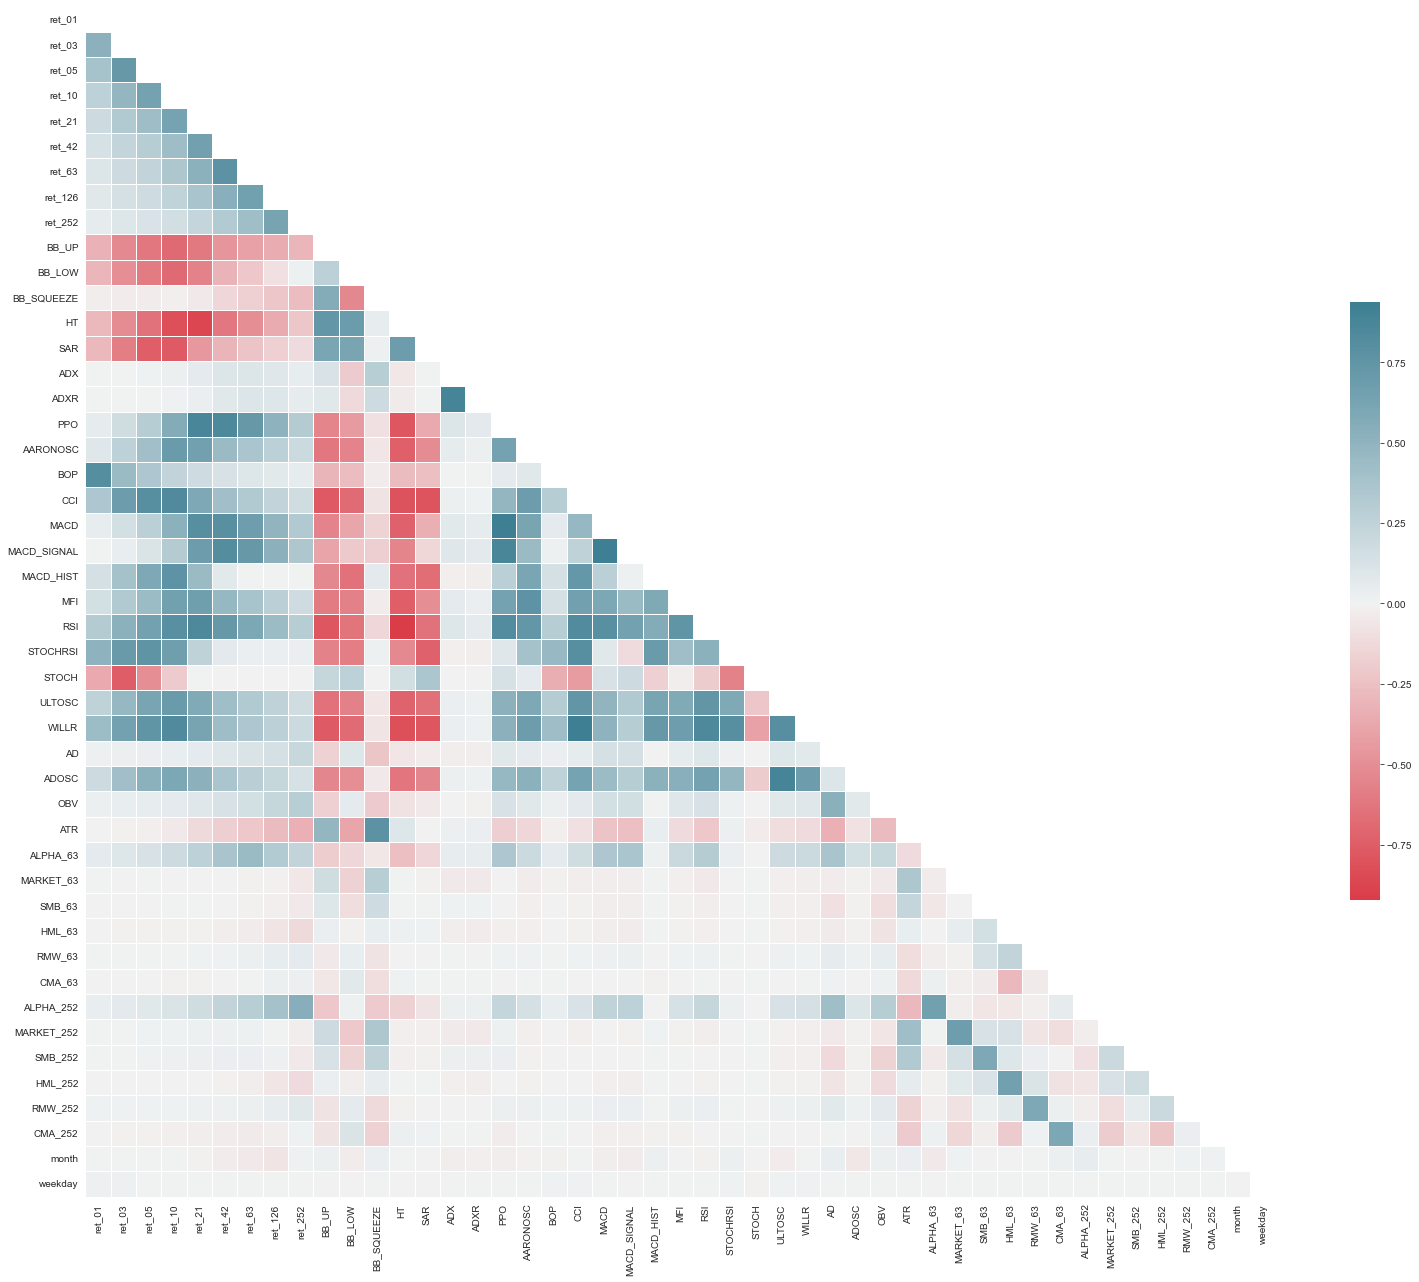

In [33]:
mask = np.triu(np.ones_like(corr_common, dtype=np.bool))
fig, ax = plt.subplots(figsize=(22, 18))
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr_common, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig.tight_layout();

The clusters show a few clusters of features that are relatively highly correlated (in absolute terms). If you are interested in reducing the number of features to speed up training or reduce memory, selecting one representative of each cluster would be a reasonable approach. 

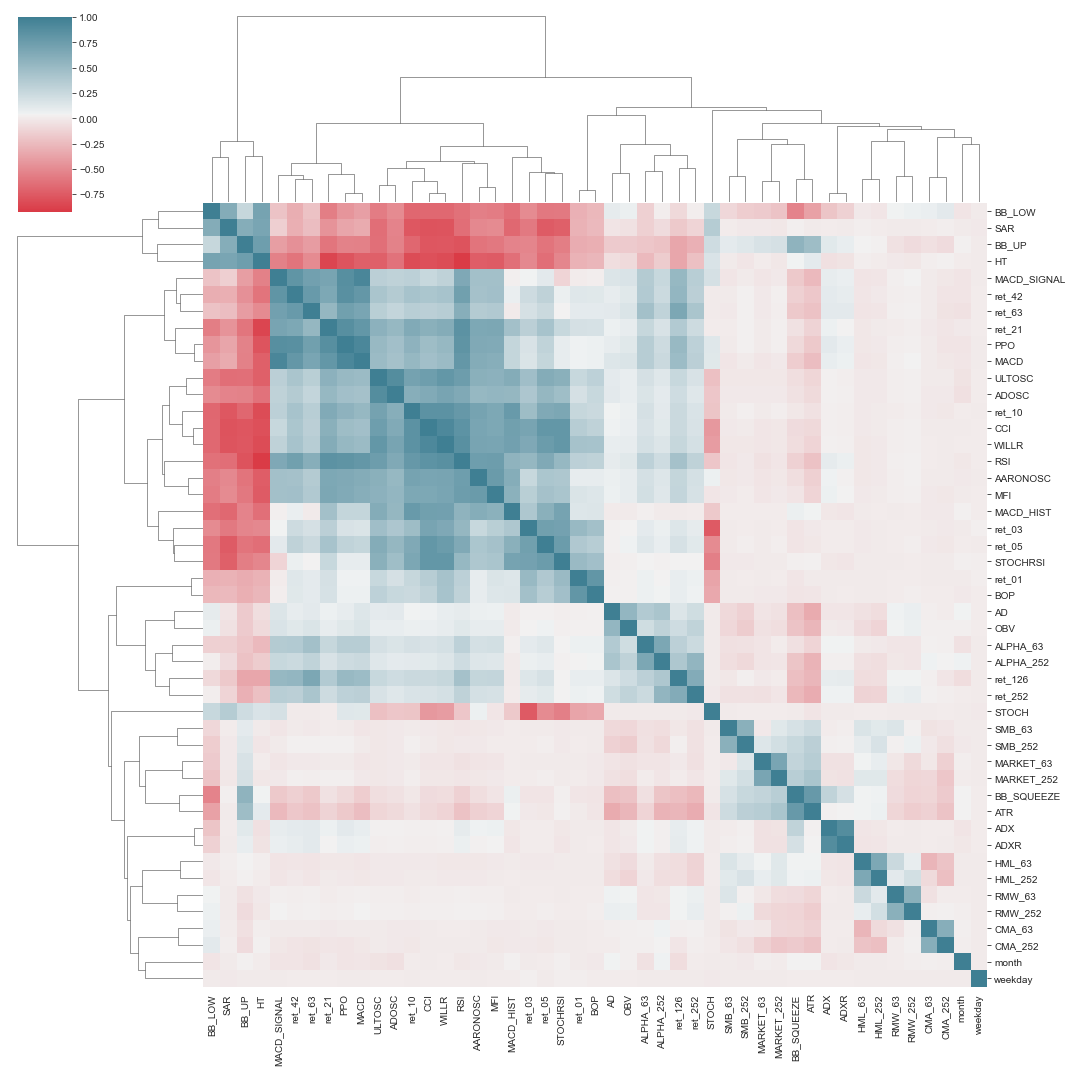

In [34]:
g = sns.clustermap(corr_common, cmap=cmap, figsize=(15, 15))

To inspect the correlation matrix, let's isolate the unique values from the corrlation matrix, excluding the diagonal:

In [35]:
corr_ = corr_common.stack().reset_index() # move column labels to rows as 2nd MultiIndex level
corr_.columns = ['x1', 'x2', 'rho']
corr_ = corr_[corr_.x1 != corr_.x2].drop_duplicates('rho')

### Top ten most correlated features

Select highest and lowest five correlation values:

In [36]:
corr_.nlargest(5, columns='rho').append(corr_.nsmallest(5, columns='rho'))

,x1,x2,rho
961,MACD,MACD_SIGNAL,0.935914
772,PPO,MACD,0.925328
921,CCI,WILLR,0.923685
1299,ULTOSC,ADOSC,0.886386
673,ADX,ADXR,0.885138
588,HT,RSI,-0.923301
200,ret_21,HT,-0.866838
153,ret_10,HT,-0.828443
592,HT,WILLR,-0.826449
583,HT,CCI,-0.806306


## Forward return correlation

Which features are most correlated with the forward returns?

In [37]:
fwd_corr = factors.drop(['ret_fwd'], axis=1).corrwith(factors.ret_fwd, method='spearman')

In [38]:
fwd_corr = fwd_corr.dropna()
fwd_corr.to_csv('forward_correlation.csv')

The features that are more correlated with the outome are more likely to help predicting it.

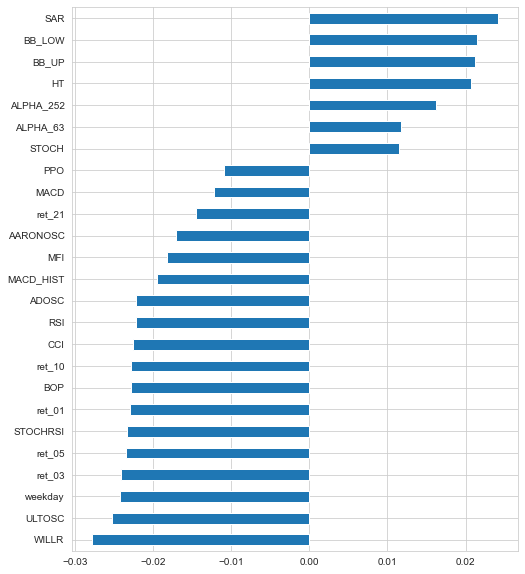

In [39]:
top50 = fwd_corr.abs().nlargest(25).index
fwd_corr.loc[top50].sort_values().plot.barh(figsize=(8, 10),
                                            legend=False);

## Mutual Information

Let's estimate the [mutual information](https://en.wikipedia.org/wiki/Mutual_information) between each feature and the forward returns for a non-linear measure of dependency (see scikit-learn [docs](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) for references on computation).

> The `mutual_info_regression` can take a while, reduce the sample size as indicated below to speed up things.

In [40]:
mi = {}
for feature in features:
    print(feature)
    df = (factors
          .loc[:, ['ret_fwd', feature]]
          .dropna()
          .sample(n=100000)) # if it takes too long or you run into resource constraints, reduce the sample size
    discrete_features = df[feature].nunique() < 20
    mi[feature] = mutual_info_regression(X=df[[feature]],
                                         y=df.ret_fwd,
                                         discrete_features=discrete_features)[0]

AARONOSC
AD
ADOSC
ADX
ADXR
ALPHA_252
ALPHA_63
ATR
BB_LOW
BB_SQUEEZE
BB_UP
BOP
CCI
CMA_252
CMA_63
HML_252
HML_63
HT
MACD
MACD_HIST
MACD_SIGNAL
MARKET_252
MARKET_63
MFI
OBV
PPO
RMW_252
RMW_63
RSI
SAR
SMB_252
SMB_63
STOCH
STOCHRSI
ULTOSC
WILLR
month
ret_01
ret_03
ret_05
ret_10
ret_126
ret_21
ret_252
ret_42
ret_63
weekday


In [41]:
mi = pd.Series(mi)
mi.to_csv('mutual_info.csv')

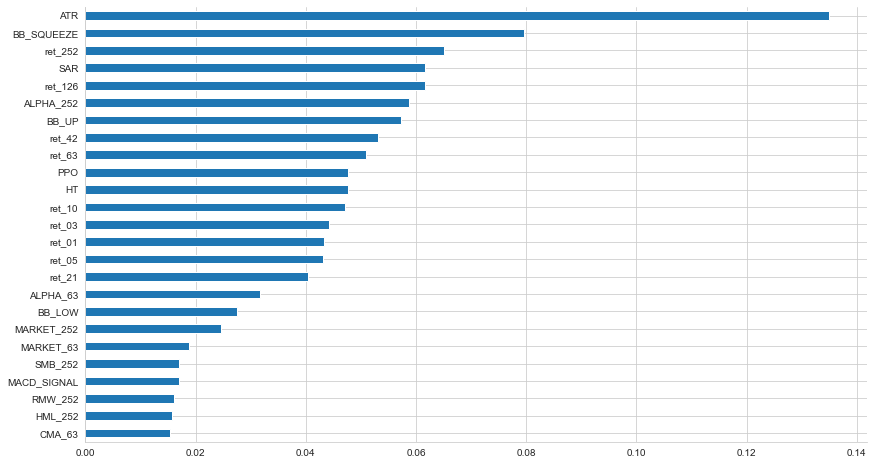

In [42]:
mi.nlargest(25).sort_values().plot.barh(figsize=(14,8))
sns.despine();

## LightGBM Feature Importance

Feature importance provides a multivariate measure of variable relevance. In other words, it tells us how useful a variable is given the other variables. 

There will be more information on using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) in Milestone 4. 

### Custom Time-Series Cross-Validation

See an example of how the `MultipleTimeSeriesCV` generates sequential, overlapping time periods for training and test in cells 11-13 [here](https://github.com/stefan-jansen/machine-learning-for-trading/blob/master/07_linear_models/05_predicting_stock_returns_with_linear_regression.ipynb).

In [43]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        """Generate the positional indices for the train-test splits for each fold"""
        unique_dates = X.index.get_level_values(self.date_idx).unique() # get unique dates
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            # create train/test start and end indices
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

### Custom Metric for Early Stopping

We can customize how LightGBM measures cross-validation progress, and will use the information coefficient. See LightGBM [docs](https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py).

> Keep in mind that early-stopping introduces lookahead bias, so do not use this to select between different models; here 'just' want to learn how useful each feature is in the context of an optimized model.

In [44]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True # whether to maximize or minimize the metric
    metric_name = 'ic'
    ic = spearmanr(preds, train_data.get_label())[0]
    return metric_name, ic, is_higher_better 

### CV Parameters

In [45]:
categoricals = ['month', 'weekday']

In [46]:
train_length = 9 * YEAR
test_length = YEAR
n_splits = 1

In [47]:
params = dict(boosting='gbdt',
              objective='regression',
              verbose=-1,
              learning_rate=0.01,
#               device='gpu', # uncomment if using GPU, e.g. in google collab
#               max_bins=63,  # uncomment if using GPU
              metric='None')

In [48]:
num_boost_round = 5000

### Create binary Datasets

See LightGBM [docs](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Dataset.html#lightgbm.Dataset) on the `lgb.Dataset`.

In [49]:
lgb_data = lgb.Dataset(data=factors.loc[:, features],
                       label=factors[fwd_returns],
                       categorical_feature=categoricals,
                       free_raw_data=False)

In [50]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          lookahead=1,
                          test_period_length=test_length,
                          train_period_length=train_length)

### Cross-validation loop

We train a model until the IC no longerr increases for 500 rounds.

In [52]:
for train_idx, test_idx in cv.split(X=factors):
    start = time()
    lgb_train = lgb_data.subset(train_idx.tolist()).construct()
    lgb_test = lgb_data.subset(test_idx.tolist()).construct()
    evals_result = {}
    model = lgb.train(params=params,
                      train_set=lgb_train,
                      num_boost_round=num_boost_round,
                      valid_sets=[lgb_train, lgb_test],
                      valid_names=['train', 'valid'],
                      feval=ic_lgbm,
                      evals_result=evals_result,
                      early_stopping_rounds=500,
                      verbose_eval=100)
    model.save_model('lgb_model.txt')

Training until validation scores don't improve for 500 rounds
[100]	train's ic: 0.104749	valid's ic: 0.0271166
[200]	train's ic: 0.133393	valid's ic: 0.0272487
[300]	train's ic: 0.153513	valid's ic: 0.0307111
[400]	train's ic: 0.166937	valid's ic: 0.0331772
[500]	train's ic: 0.179425	valid's ic: 0.0341619
[600]	train's ic: 0.190738	valid's ic: 0.0341195
[700]	train's ic: 0.199613	valid's ic: 0.032304
[800]	train's ic: 0.20576	valid's ic: 0.031414
[900]	train's ic: 0.211951	valid's ic: 0.0302954
[1000]	train's ic: 0.216426	valid's ic: 0.0300971
Early stopping, best iteration is:
[524]	train's ic: 0.182715	valid's ic: 0.0347531


We can persist the model to generate predictions later:

In [53]:
model = lgb.Booster(model_file='lgb_model.txt')

### Generate and evaluate predictions

In [54]:
# select test features and label
test_set = factors.iloc[test_idx, :]
X_test = test_set.loc[:, model.feature_name()]
y_test = test_set.loc[:, fwd_returns[0]]

# make predictions
y_pred = model.predict(X_test)
cv_preds = y_test.to_frame('y_test').assign(y_pred=y_pred)

# compute daily correlation
by_day = cv_preds.groupby(level='date')
ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x.y_pred)[0])
daily_ic_mean = ic_by_day.mean()
daily_ic_std = ic_by_day.std()
daily_ic_median = ic_by_day.median()
ic = spearmanr(cv_preds.y_test, cv_preds.y_pred)[0]
print(f'Overall IC: {ic:6.2%} | Average Daily IC: {daily_ic_mean: 6.2%} | Coefficient of Variation for daily IC: {daily_ic_std/daily_ic_mean: 5.2} | Median Daily IC: {daily_ic_median: 6.2%}')

Overall IC:  3.48% | Average Daily IC:  2.42% | Coefficient of Variation for daily IC:   6.4 | Median Daily IC:  1.88%


While the daily average of the IC is positive at 0.028, it is also quite volatile. In other words, predictions will do quite poorly occasionally (and much better otherwise).

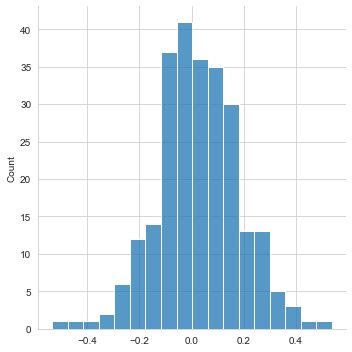

In [55]:
sns.displot(ic_by_day);

Higher momemts (Skew and Kurtosis) confirm that the returns are only slightly negatively skewed but have significantly fatter tails than a normal distribution (pandas uses [Fisher's definition](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.kurtosis.html)).

In [56]:
pd.Series({'Mean': ic_by_day.mean(), 
           'Std. Dev': ic_by_day.std(), 
           'Median': ic_by_day.median(), 
           'Skew': ic_by_day.skew(), 
           'Kurtosis': ic_by_day.kurtosis()}).apply(lambda x: f'{x:.4f}')

Mean         0.0242
Std. Dev     0.1559
Median       0.0188
Skew        -0.0098
Kurtosis     0.6980
dtype: object

### Compute Feature Importance

In [57]:
def get_fi(model):
    """Compute LightGBM feature imporance"""
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

In [58]:
fi = get_fi(model)
fi.to_csv('feature_importance.csv')

In [59]:
cv_result = pd.DataFrame({'Train Set': evals_result['train']['ic'], 
                          'Validation Set': evals_result['valid']['ic']})

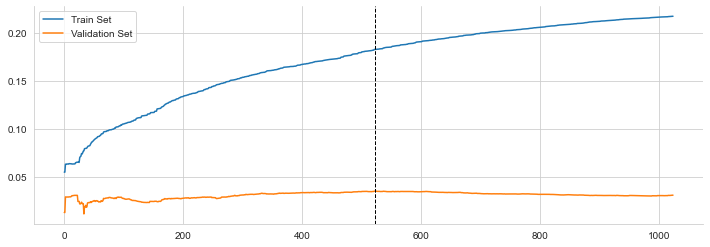

In [60]:
ax = cv_result.plot(figsize=(12, 4))
ax.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1)
sns.despine();

Selecting the most important features this way has the advantage of sacrificing less predictive performance for a given reduction in training time or inference latency.

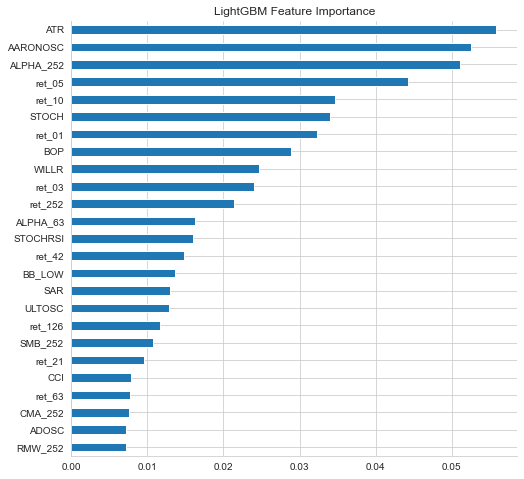

In [61]:
fi.drop(categoricals).nlargest(25).sort_values().plot.barh(figsize=(8, 8),
                                        title='LightGBM Feature Importance')
sns.despine();

## SHapley Additive exPlanation (SHAP) Values

At the 2017 NIPS conference, Scott Lundberg and Su-In Lee, from the University of
Washington, presented a new and more accurate approach to explaining the contribution
of individual features to the output of tree ensemble models called SHapley Additive
exPlanations, or SHAP values.

This new algorithm departs from the observation that feature-attribution methods for tree
ensembles, such as the ones we looked at earlier, are inconsistent—that is, a change in a
model that increases the impact of a feature on the output can lower the importance values
for this feature.

SHAP values unify ideas from collaborative game theory and local explanations, and
have been shown to be theoretically optimal, consistent, and locally accurate based on
expectations. Most importantly, Lundberg and Lee have developed an algorithm that
manages to reduce the complexity of computing these model-agnostic, additive feature-
attribution methods from O(TLDM) to O(TLD$^2$), where T and M are the number of trees and
features, respectively, and D and L are the maximum depth and number of leaves across
the trees. This important innovation permits the explanation of predictions from previously
intractable models with thousands of trees and features in a fraction of a second. An open
source implementation became available in late 2017 and is compatible with XGBoost,
LightGBM, CatBoost, and sklearn tree models.

Shapley values originated in game theory as a technique for assigning a value to each
player in a collaborative game that reflects their contribution to the team's success.
SHAP values are an adaptation of the game theory concept to tree-based models and are
calculated for each feature and each sample. They measure how a feature contributes to the
model output for a given observation. For this reason, SHAP values provide differentiated
insights into how the impact of a feature varies across samples, which is important, given
the role of interaction effects in these nonlinear models.

See SHAP Values [GitHub repo](https://github.com/slundberg/shap) for docs and links to papers.

To get a high-level overview of the feature importance across a number of samples, there
are two ways to plot the SHAP values: a simple average across all samples that resembles
the global feature-importance measures computed previously (as shown in the left-hand
panel of Figure 12.15), or a scatterplot to display the impact of every feature for every
sample (as shown in the right-hand panel of the figure). They are very straightforward
to produce using a trained model from a compatible library and matching input data, as
shown in the following code:

In [62]:
shap.initjs()

In [63]:
model = lgb.Booster(model_file='lgb_model.txt')

In [64]:
explainer = shap.TreeExplainer(model)

In [66]:
# workaround for SHAP version 0.35: https://github.com/slundberg/shap/issues/794
model.params['objective'] = 'regression'

In [67]:
shap_values = explainer.shap_values(factors.iloc[test_idx, :].loc[:, model.feature_name()])

In [68]:
np.save('shap_values.npy', shap_values)

In [69]:
shap_values = np.load('shap_values.npy')

The scatterplot sorts features by their total SHAP values across all samples and then shows
how each feature impacts the model output, as measured by the SHAP value, as a function
of the feature's value, represented by its color, where red represents high values and blue
represents low values relative to the feature's range:

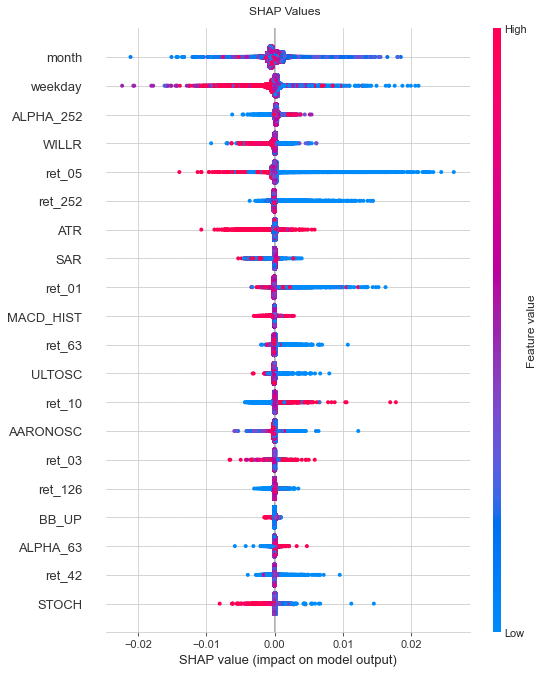

In [70]:
shap.summary_plot(shap_values,
                  factors
                  .iloc[test_idx, :]
                  .loc[:, model.feature_name()],
                  show=False)

plt.gcf().suptitle('SHAP Values')
plt.gcf().tight_layout()

In [71]:
shap_values = pd.DataFrame(shap_values, columns=features)

In [72]:
shap_summary = np.abs(shap_values).mean()
shap_summary /= shap_summary.sum()

The SHAP method clearly arrives at a different order for the most important variables.

In [73]:
shap_summary.nlargest(20)

month        0.253141
weekday      0.152459
ALPHA_252    0.089679
WILLR        0.057036
ret_05       0.048114
ret_252      0.046907
ATR          0.041250
SAR          0.030125
ret_01       0.021906
MACD_HIST    0.021852
ret_63       0.019495
ULTOSC       0.018334
ret_10       0.018234
AARONOSC     0.016846
ret_03       0.016141
ret_126      0.015713
BB_UP        0.015575
ALPHA_63     0.014400
ret_42       0.010390
STOCH        0.010100
dtype: float64

In [74]:
shap_summary.to_csv('shap_values.csv')

## Comparison

Let's take a look how the rankings by the various bivariate and multivariate measures of feature relevance differ.

In [75]:
mi = pd.read_csv('mutual_info.csv', index_col=0, squeeze=True)
fwd_corr = pd.read_csv('forward_correlation.csv', index_col=0, squeeze=True)

In [76]:
stats = (mi.to_frame('Mutual Information')
         .join(fwd_corr.to_frame('Information Coefficient'))
         .join(fi.to_frame('Feature Importance'))
         .join(shap_summary.to_frame('SHAP Values')))

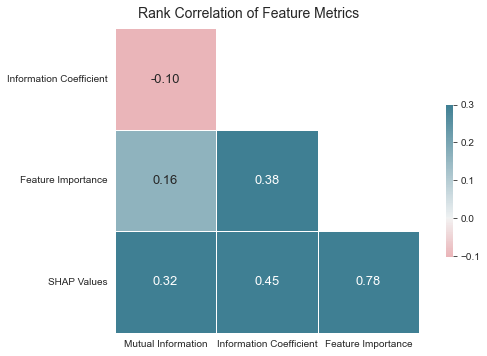

In [77]:
cols = {'Information Coefficient': stats['Information Coefficient'].abs()}

corr = stats.assign(**cols).corr('spearman')

mask = np.triu(np.ones_like(corr, dtype=np.bool))
corr = corr.iloc[1:, :-1]
mask = mask[1:, :-1]

fig, ax = plt.subplots(figsize=(8, 5))

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr, mask=mask,
            cmap=cmap,
            vmax=.3, center=0,
            square=True, linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=True, fmt='.2f',
            annot_kws={"size": 13})

plt.xticks(rotation=0)
fig.suptitle('Rank Correlation of Feature Metrics', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.92)

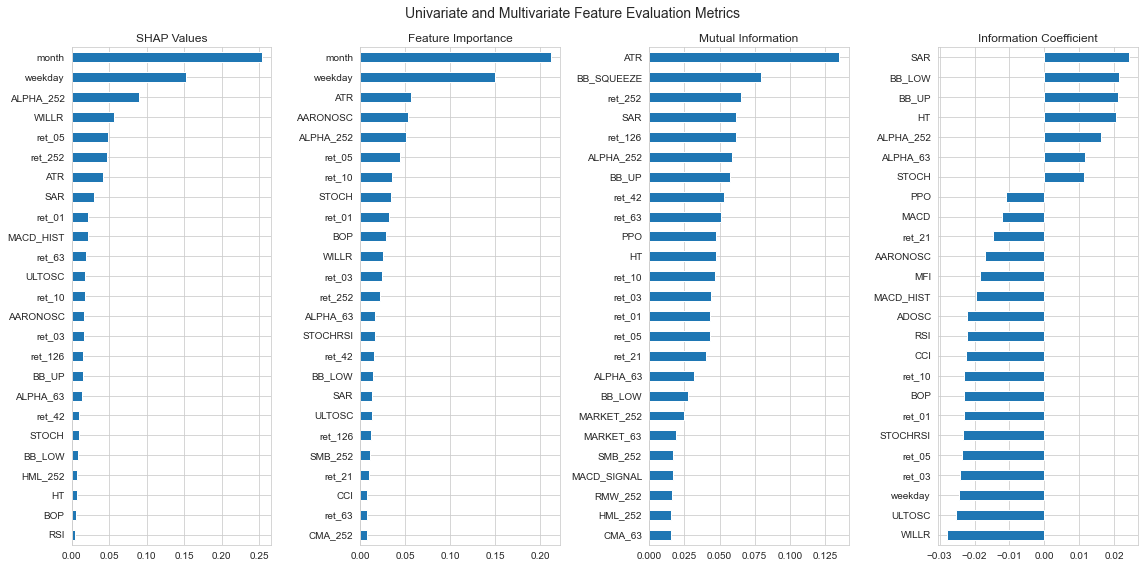

In [78]:
top_n = 25
fig, axes = plt.subplots(ncols=4, figsize=(16, 8))

shap_summary.nlargest(top_n).sort_values().plot.barh(ax=axes[0], title='SHAP Values')

fi.nlargest(top_n).sort_values().plot.barh(ax=axes[1], title='Feature Importance')

mi.nlargest(top_n).sort_values().plot.barh(ax=axes[2], title='Mutual Information')

top_corr = fwd_corr.abs().nlargest(top_n).index
fwd_corr.loc[top_corr].sort_values().plot.barh(ax=axes[3], title='Information Coefficient')

fig.suptitle('Univariate and Multivariate Feature Evaluation Metrics', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.91);

For a single ranking, we can average over the three measures that are most in agreement with each other; the low correlation of mutual information with the remainder would deserve some additional investigation.

In [79]:
top_ranked = stats.drop('Mutual Information', axis=1).abs().rank(ascending=False).mean(1)

In [80]:
top_ranked.to_csv('top_features.csv')

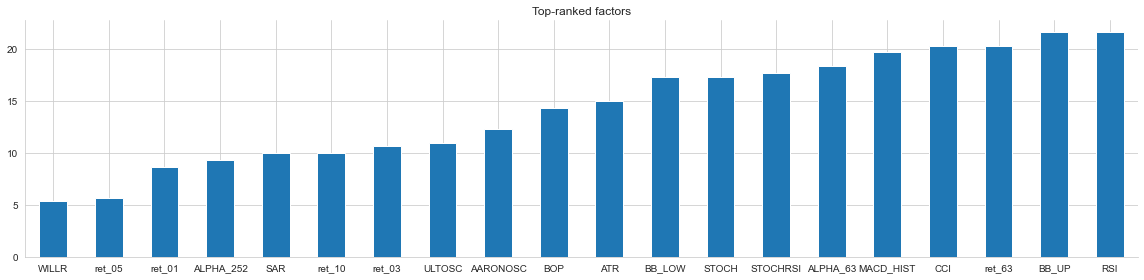

In [81]:
top_ranked.drop(categoricals).nsmallest(20).plot.bar(figsize=(16, 4), rot=0, title='Top-ranked factors')
sns.despine()
plt.tight_layout();

## Alphalens Analysis

Alphalens is a Python Library (originally developed by Quantopian) for performance analysis of predictive (alpha) stock factors. Alphalens works great with the Zipline open source backtesting library, and Pyfolio which provides performance and risk analysis of financial portfolios. 

The main function of Alphalens is to surface the most relevant statistics and plots about an alpha factor, including:

- Returns Analysis
- Information Coefficient Analysis
- Turnover Analysis
- Grouped Analysis

See Alphalens [docs](https://alphalens.ml4trading.io) and [example notebooks](https://github.com/stefan-jansen/alphalens-reloaded/tree/master/alphalens/examples) for additional detail.

In [82]:
tickers = factors.index.unique('ticker')

### Get trade prices

We need market prices for the relevant period:

In [83]:
def get_trade_prices(tickers):
    return (pd.read_hdf(DATA_STORE, 'us_stocks')
              .loc[idx[tickers, '2006':'2017'], 'open']
              .unstack('ticker')
              .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [84]:
trade_prices = get_trade_prices(tickers)

In [85]:
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 500 entries, A to ZMH
dtypes: float64(500)
memory usage: 11.5 MB


### Select factor

We also need the factor signals that we want to evaluate:

In [86]:
alpha = 'ATR'

In [87]:
factor = (factors[alpha]
          .unstack('ticker')
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())

### Generate Alphalens input data

With a signal and pricing data creating a factor "tear sheet" is a two step process:
1. Bring data into the right format
2. Select desired tearsheet.

In [88]:
factor_data = utils.get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   max_loss=0.35,
                                                   periods=(1, 5, 10)).sort_index()
factor_data.info()

Dropped 2.7% entries from factor data: 2.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1358061 entries, (Timestamp('2006-01-23 00:00:00+0000', tz='UTC', freq='C'), 'A') to (Timestamp('2016-12-29 00:00:00+0000', tz='UTC', freq='C'), 'ZION')
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   1D               1358061 non-null  float64
 1   5D               1358061 non-null  float64
 2   11D              1358061 non-null  float64
 3   factor           1358061 non-null  float64
 4   factor_quantile  1358061 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 57.1+ MB


### Create Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,0.000081,0.076998,0.017367,0.008179,272203,20.043503
2,0.011363,0.092474,0.022592,0.010599,271404,19.984669
3,0.013188,0.109139,0.027144,0.013145,271143,19.965451
4,0.015607,0.139410,0.032996,0.016438,271404,19.984669
5,0.019018,1.141389,0.048438,0.030306,271907,20.021707


Returns Analysis


,1D,5D,11D
Ann. alpha,-0.029,-0.032,-0.030
beta,0.511,0.546,0.540
Mean Period Wise Return Top Quantile (bps),2.017,1.798,1.447
Mean Period Wise Return Bottom Quantile (bps),-1.439,-1.372,-1.205
Mean Period Wise Spread (bps),3.456,2.963,2.462


Information Analysis


,1D,5D,11D
IC Mean,-0.012,-0.007,-0.003
IC Std.,0.256,0.263,0.252
Risk-Adjusted IC,-0.046,-0.025,-0.012
t-stat(IC),NaN,NaN,NaN
p-value(IC),NaN,NaN,NaN
IC Skew,NaN,NaN,NaN
IC Kurtosis,NaN,NaN,NaN


Turnover Analysis


,1D,5D,11D
Quantile 1 Mean Turnover,0.048,0.124,0.185
Quantile 2 Mean Turnover,0.109,0.277,0.398
Quantile 3 Mean Turnover,0.121,0.308,0.435
Quantile 4 Mean Turnover,0.099,0.258,0.374
Quantile 5 Mean Turnover,0.040,0.106,0.158


,1D,5D,11D
Mean Factor Rank Autocorrelation,0.995,0.97,0.94


<Figure size 432x288 with 0 Axes>

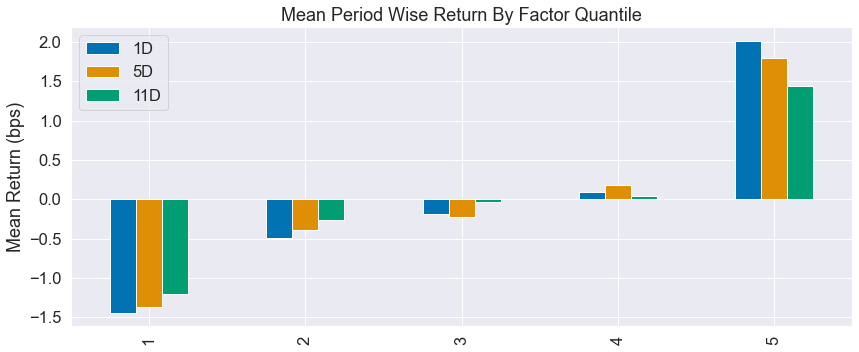

In [89]:
create_summary_tear_sheet(factor_data)

Returns Analysis


,1D,5D,11D
Ann. alpha,-0.029,-0.032,-0.030
beta,0.511,0.546,0.540
Mean Period Wise Return Top Quantile (bps),2.017,1.798,1.447
Mean Period Wise Return Bottom Quantile (bps),-1.439,-1.372,-1.205
Mean Period Wise Spread (bps),3.456,2.963,2.462


<Figure size 432x288 with 0 Axes>

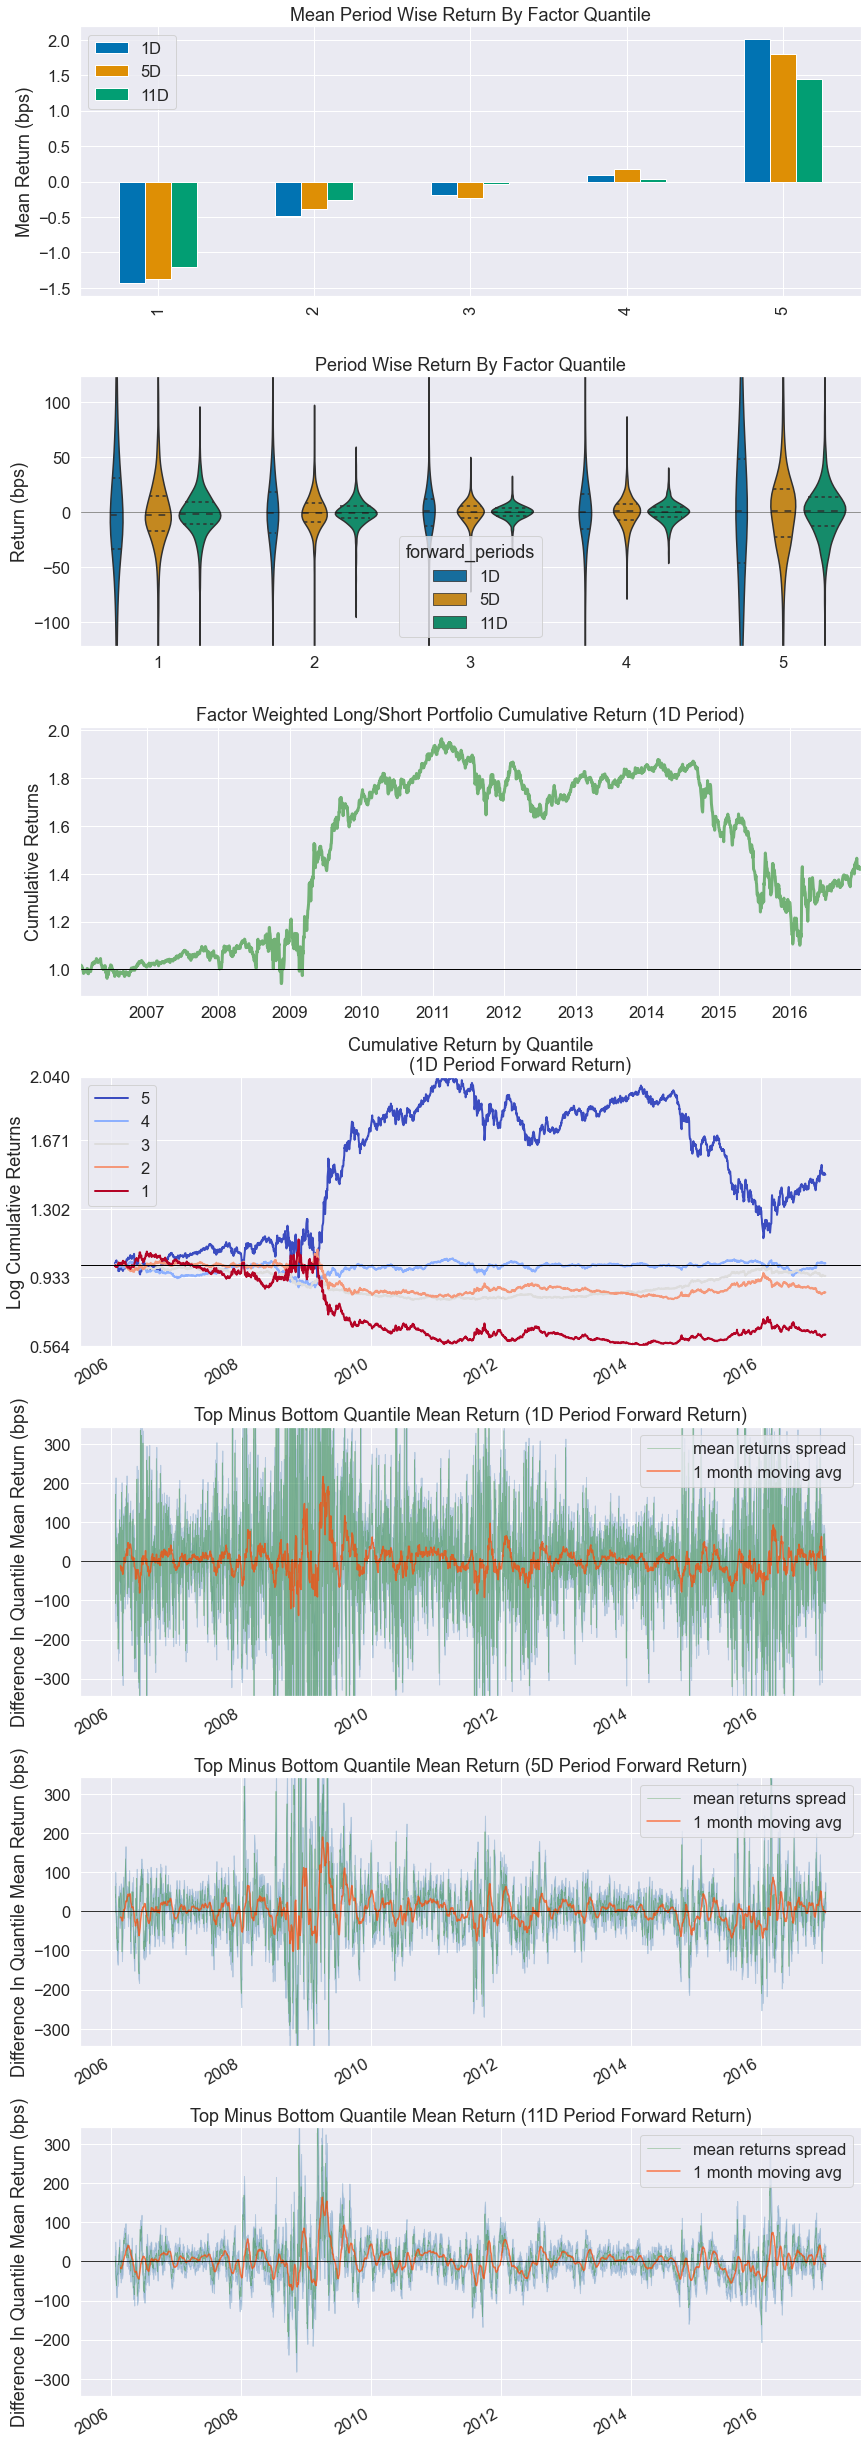

In [90]:
create_returns_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,0.000081,0.076998,0.017367,0.008179,272203,20.043503
2,0.011363,0.092474,0.022592,0.010599,271404,19.984669
3,0.013188,0.109139,0.027144,0.013145,271143,19.965451
4,0.015607,0.139410,0.032996,0.016438,271404,19.984669
5,0.019018,1.141389,0.048438,0.030306,271907,20.021707


Returns Analysis


,1D,5D,11D
Ann. alpha,-0.029,-0.032,-0.030
beta,0.511,0.546,0.540
Mean Period Wise Return Top Quantile (bps),2.017,1.798,1.447
Mean Period Wise Return Bottom Quantile (bps),-1.439,-1.372,-1.205
Mean Period Wise Spread (bps),3.456,2.963,2.462


<Figure size 432x288 with 0 Axes>

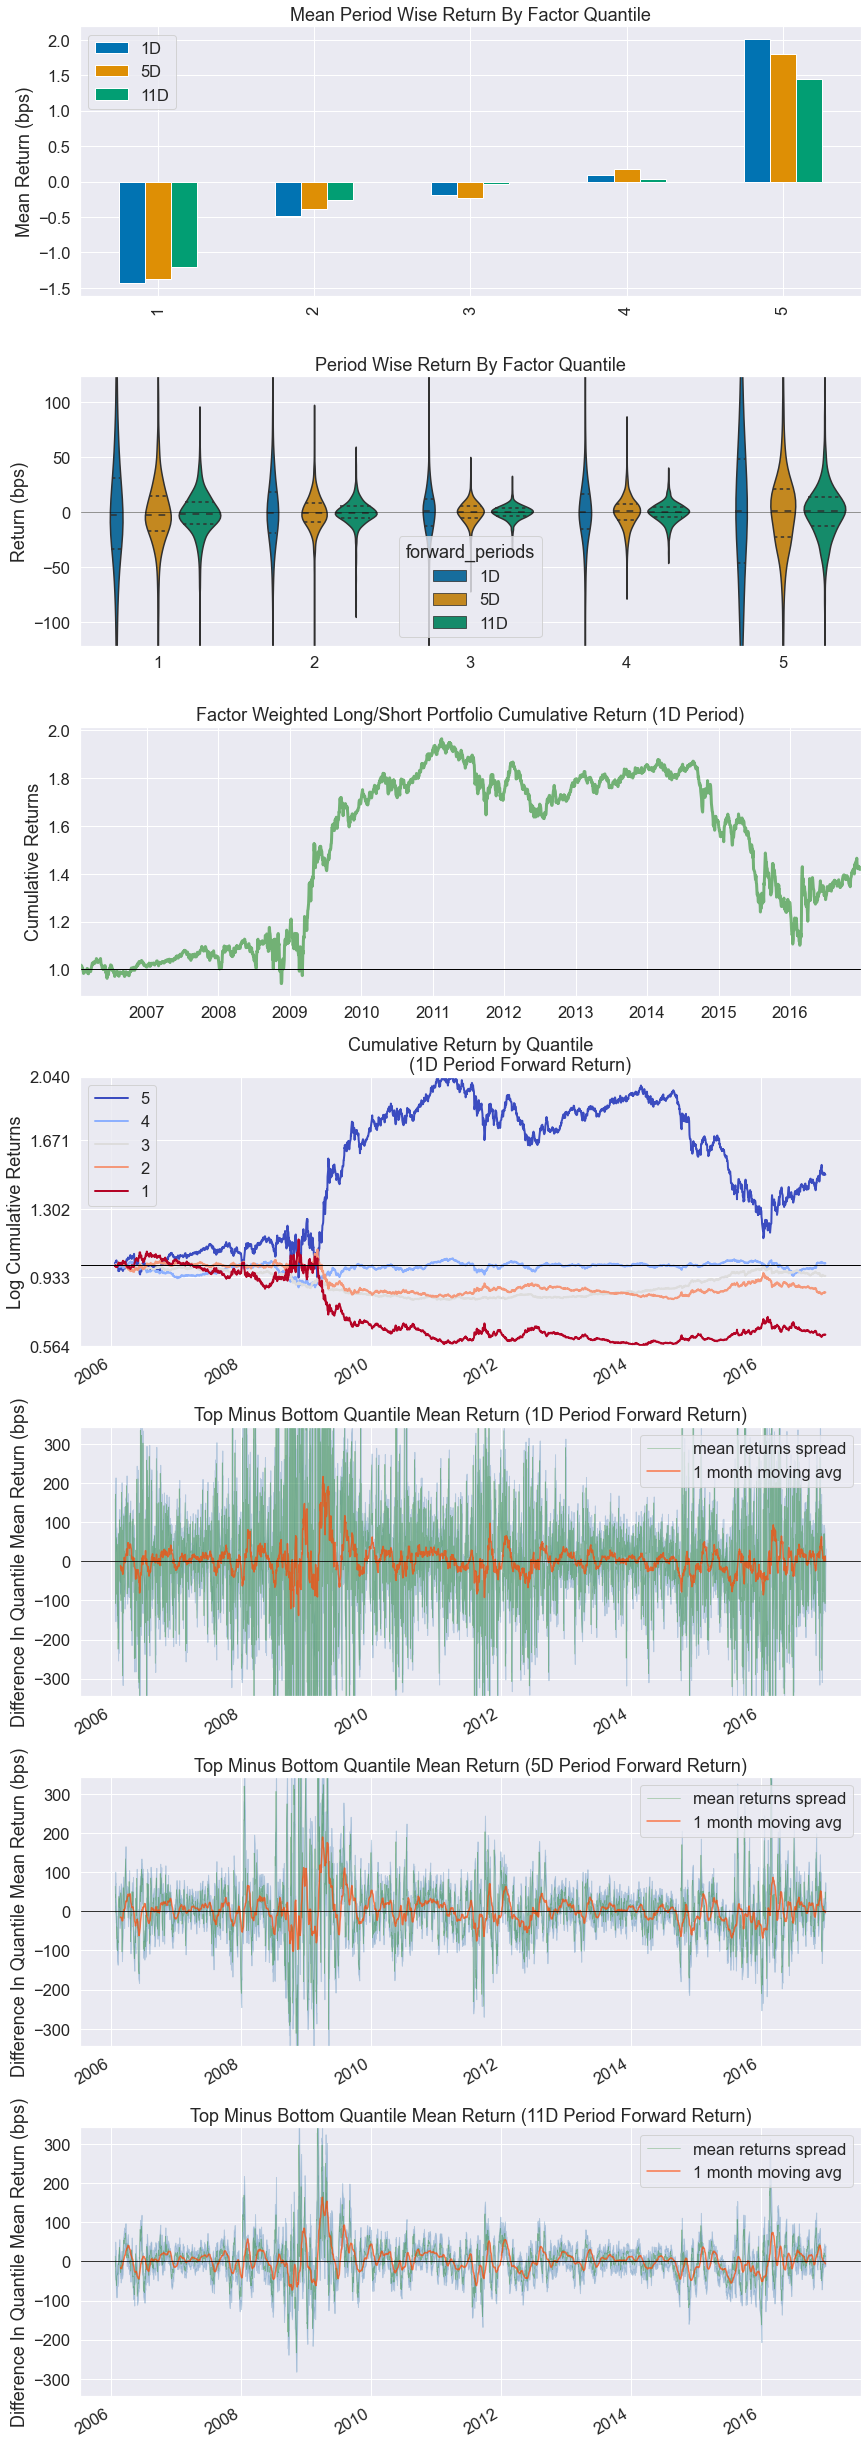

Information Analysis


,1D,5D,11D
IC Mean,-0.012,-0.007,-0.003
IC Std.,0.256,0.263,0.252
Risk-Adjusted IC,-0.046,-0.025,-0.012
t-stat(IC),NaN,NaN,NaN
p-value(IC),NaN,NaN,NaN
IC Skew,NaN,NaN,NaN
IC Kurtosis,NaN,NaN,NaN


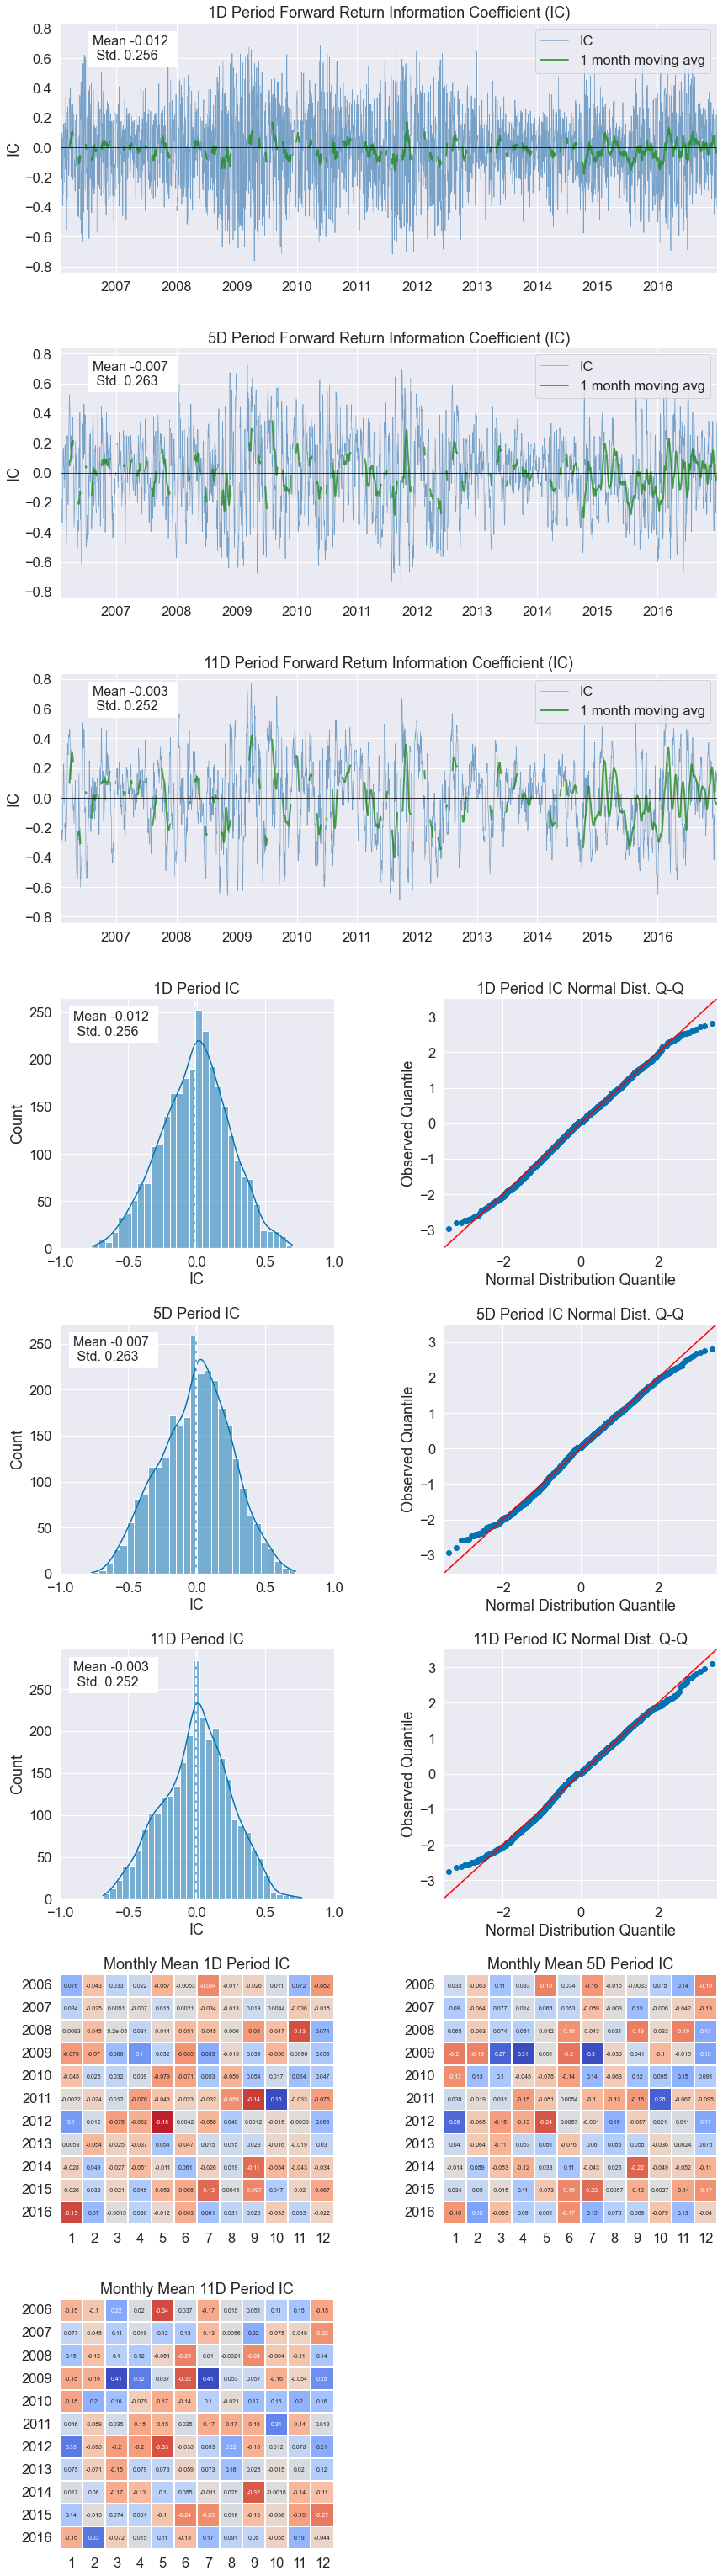

Turnover Analysis


,1D,5D,11D
Quantile 1 Mean Turnover,0.048,0.124,0.185
Quantile 2 Mean Turnover,0.109,0.277,0.398
Quantile 3 Mean Turnover,0.121,0.308,0.435
Quantile 4 Mean Turnover,0.099,0.258,0.374
Quantile 5 Mean Turnover,0.040,0.106,0.158


,1D,5D,11D
Mean Factor Rank Autocorrelation,0.995,0.97,0.94


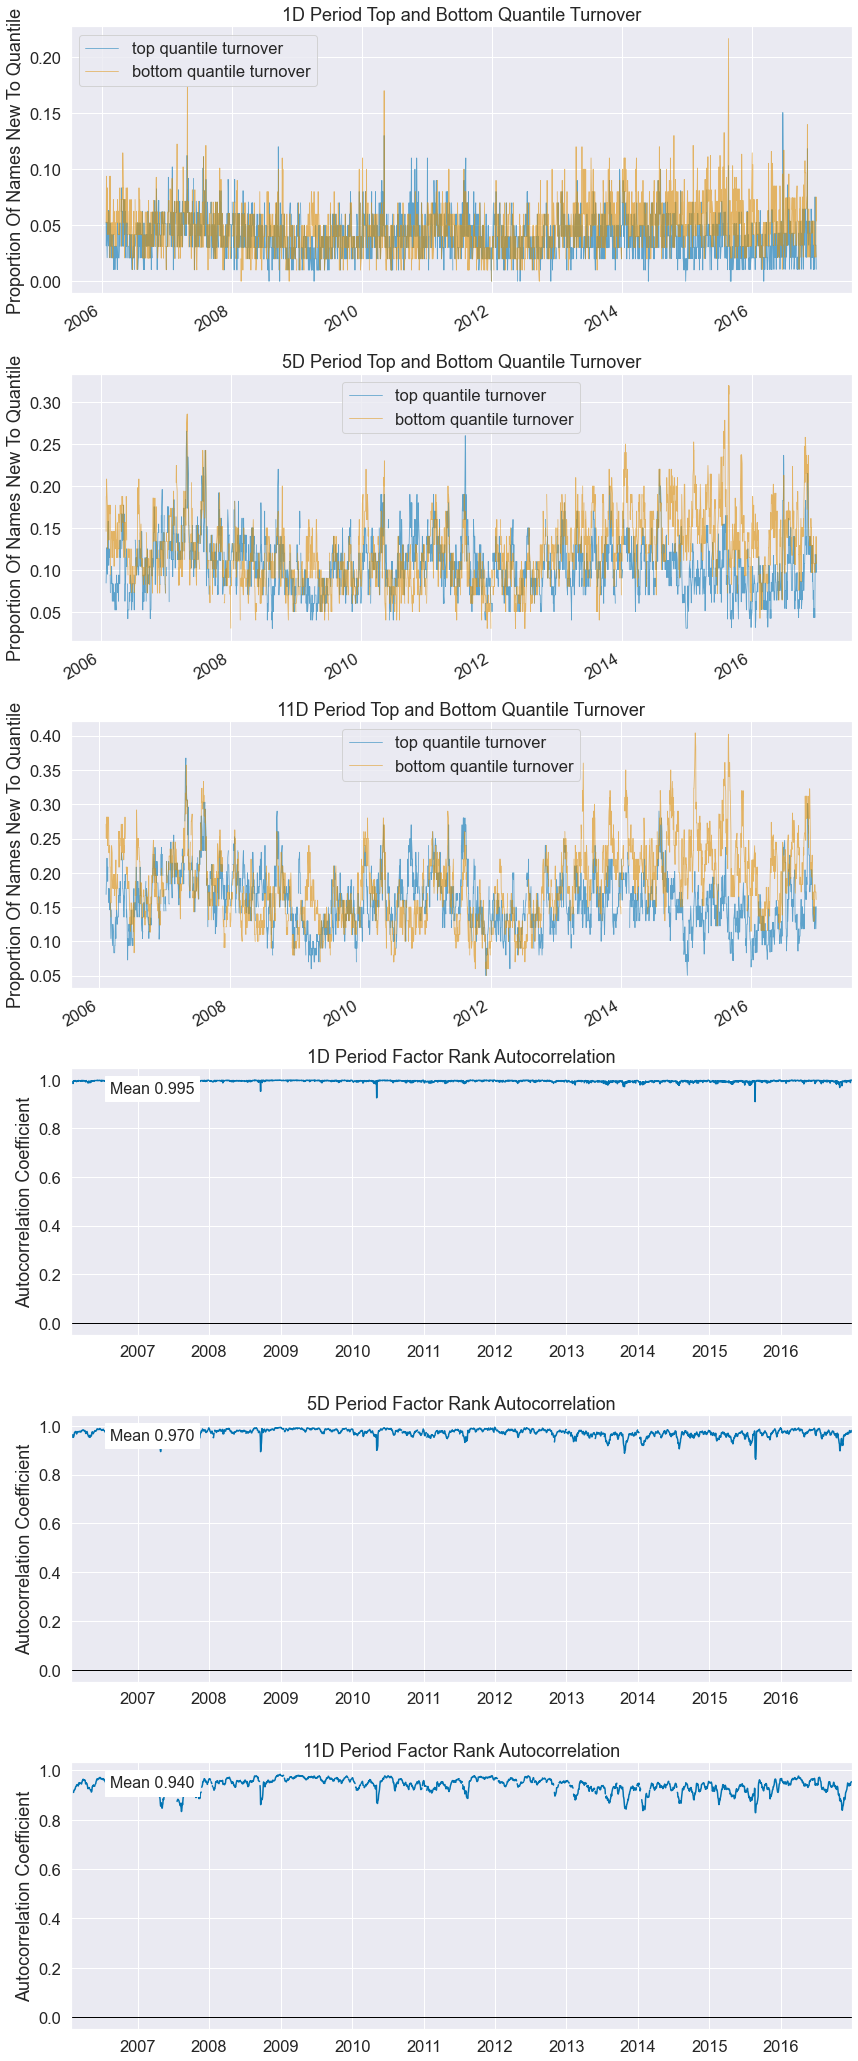

In [91]:
create_full_tear_sheet(factor_data)